In [33]:
!pip install qiskit-aer
!pip install qiskit_experiments
!pip install azure-quantum[qiskit]==0.23.201228b1

from azure.quantum import Workspace
workspace = Workspace (
    subscription_id = "33e6f75e-0499-425c-8b7d-9f593dde82b6",
    resource_group = "aqet",
    name = "chem560",
    location = "westus"
)

from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider (
    resource_id = "/subscriptions/33e6f75e-0499-425c-8b7d-9f593dde82b6/resourceGroups/AQET/providers/Microsoft.Quantum/Workspaces/CHEM560",
    location = "westus"
)

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [34]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit import transpile
from qiskit import Aer
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit_experiments.library import StateTomography
from qiskit.quantum_info import DensityMatrix
import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import NoiseModel, thermal_relaxation_error
from qiskit.providers.aer import AerSimulator

## a)
To start, we will compute the $ \epsilon(\rho) $ from the given Kraus operators. The Kraus operators are given as 
$$
E_0 = \begin{bmatrix} 1 & 0 \\ 0 & \sqrt{1-\lambda} \end{bmatrix}
$$
$$
E_1 = \begin{bmatrix} 0 & 0 \\ 0 & \sqrt{\lambda} \end{bmatrix}
$$
And to generate the new Bloch sphere, we can compute $\epsilon (\rho)$ by

$$
\epsilon = \sum_{i}E_i\rho E_i^\dagger = E_0 \rho E_0 + E_1\rho E_1
$$
Where $\rho$ is defined in the Bloch basis as
$$
\rho = \frac{1}{2}\begin{bmatrix}1 + r_z & r_x-ir_y \\ r_x+ir_y & 1 - r_z \end{bmatrix}
$$
For sake of brevity, I used Symbolab in order to compute the matrix products here. In this case, we get the overall expression for the "new" Bloch sphere as
$$
\epsilon = \begin{bmatrix}1+r_z &\sqrt{1-\lambda}(r_x-ir_y)\\ \sqrt{1-\lambda}(r_x+ir_y)&1-r_z\end{bmatrix}
$$

By inspection, we see two things. First, there's no alteration along the $|0\rangle \langle 0|$ and $|1\rangle \langle 1|$ projections on the sphere, and the 
off-diagonals are modulated by the $\lambda$ coefficient. Whenever we have maximal damping, we get a complete collapse of the $r_x$ and $r_y$ contributions, so we 
collapse to a sphere that lies solely on the $z$-axis. We can plot with an arbitrary $\lambda = 0.75$ to show the Bloch sphere transformation.

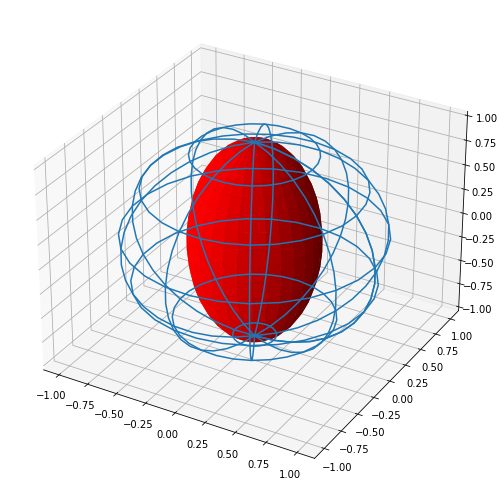

In [63]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = [7.00*2, 3.50*2]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
r = 0.05
lam=0.75
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
x2 = np.sqrt(1-lam)*np.cos(u) * np.sin(v)
y2 = np.sqrt(1-lam)*np.sin(u) * np.sin(v)
z2 = np.cos(v)
ax.plot_wireframe(x, y, z, rstride=3,cstride=3)
ax.plot_surface(x2,y2,z2,color='red')
plt.show()

Now, moving toward the generalized amplitude damping, we again have definitions for our Kraus operators
$$

E_0 = \sqrt{p}\begin{bmatrix} 1 & 0 \\ 0 & \sqrt{1-\lambda} \end{bmatrix}, \ 

E_1 = \sqrt{p}\begin{bmatrix} 0 & \sqrt{\lambda} \\ 0 & 0 \end{bmatrix}, \ 

E_2 = \sqrt{1-p}\begin{bmatrix} \sqrt{1-\lambda} & 0 \\ 0 & 1 \end{bmatrix}, \ 

E_3 = \sqrt{1-p}\begin{bmatrix} 0 & 0 \\ \sqrt{\lambda} & 0 \end{bmatrix}

$$

and we can determine the new Bloch sphere from 
$$
\epsilon = \sum_{i}E_i\rho E_i^\dagger = E_0 \rho E_0 + E_1\rho E_1 + E_2 \rho E_2 + E_3 \rho E_3
$$
Again, substituting the previous quantities into the above and simplifying yields the new expression 
$$
\epsilon = \frac{1}{2}\begin{bmatrix}\gamma (2p-1) + r_z(1-\gamma) + 1 & r_x\sqrt{1-\gamma}-ir_y\sqrt{1-\gamma} \\
           r_x\sqrt{1-\gamma}+ir_y\sqrt{1-\gamma} & \gamma(1-2p)+r_z(\gamma-1)+1  \end{bmatrix} 
$$
From the above, if we make the substitutions $r_z'=\gamma (2p-1) + r_z(1-\gamma)$, $r_y'=r_y\sqrt{1-\gamma}$, and $r_x'=r_x\sqrt{1-\gamma}$.
We expect this to be the case; a general amplitude damping can be cast into a new Bloch sphere based on the two parameters $\gamma$ and p. Note that
we have dependence on two parameters.

To show the variance in plotting by these parameters, I will plot a survey of three different values of $\gamma$ and p.

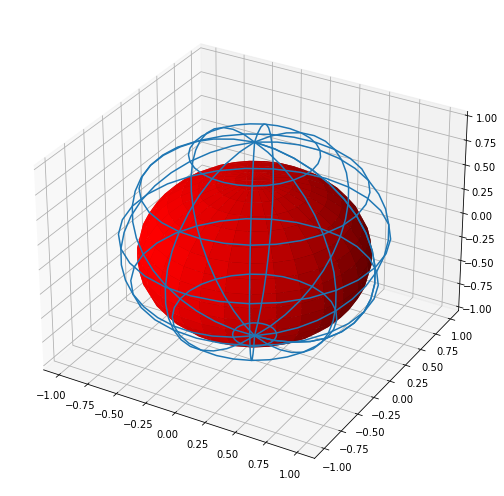

In [64]:
## gamma = 0.25 , p = 0.25
plt.rcParams["figure.figsize"] = [7.00*2, 3.50*2]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
r = 0.05
lam=0.25
p = 0.25
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
x2 = np.sqrt(1-lam)*np.cos(u) * np.sin(v)
y2 = np.sqrt(1-lam)*np.sin(u) * np.sin(v)
z2 = lam*(2*p-1)+np.cos(v)*(1-lam)
ax.plot_wireframe(x, y, z, rstride=3,cstride=3)
ax.plot_surface(x2,y2,z2,color='red')
plt.show()

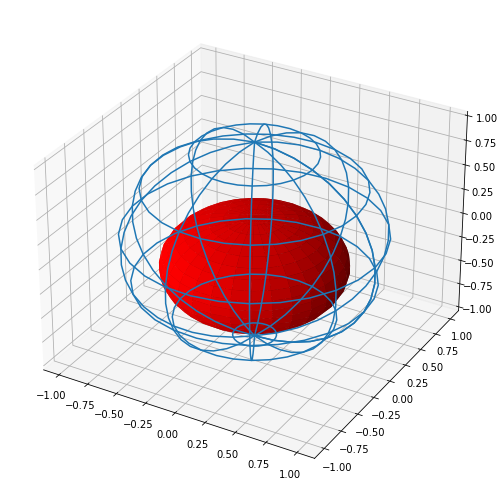

In [65]:
## gamma = 0.5 , p = 0.25
plt.rcParams["figure.figsize"] = [7.00*2, 3.50*2]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
r = 0.05
lam=0.5
p = 0.25
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
x2 = np.sqrt(1-lam)*np.cos(u) * np.sin(v)
y2 = np.sqrt(1-lam)*np.sin(u) * np.sin(v)
z2 = lam*(2*p-1)+np.cos(v)*(1-lam)
ax.plot_wireframe(x, y, z, rstride=3,cstride=3)
ax.plot_surface(x2,y2,z2,color='red')
plt.show()

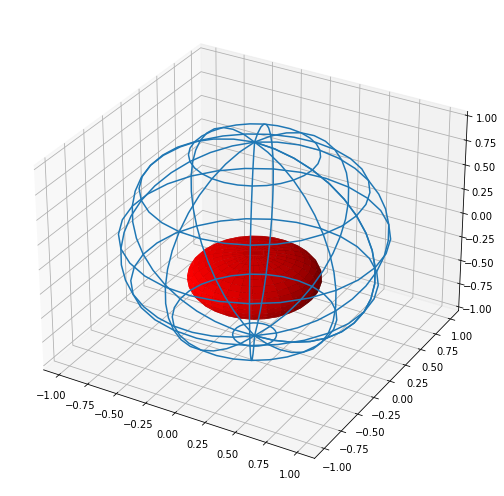

In [66]:
## gamma = 0.75 , p = 0.25
plt.rcParams["figure.figsize"] = [7.00*2, 3.50*2]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
r = 0.05
lam=0.75
p = 0.25
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
x2 = np.sqrt(1-lam)*np.cos(u) * np.sin(v)
y2 = np.sqrt(1-lam)*np.sin(u) * np.sin(v)
z2 = lam*(2*p-1)+np.cos(v)*(1-lam)
ax.plot_wireframe(x, y, z, rstride=3,cstride=3)
ax.plot_surface(x2,y2,z2,color='red')
plt.show()

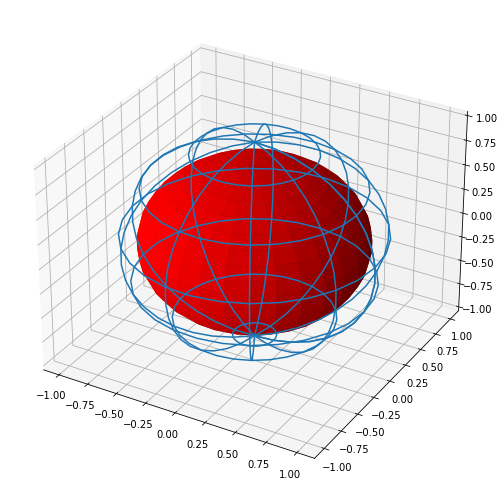

In [67]:
## gamma = 0.25 , p = 0.5
plt.rcParams["figure.figsize"] = [7.00*2, 3.50*2]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
r = 0.05
lam=0.25
p = 0.5
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
x2 = np.sqrt(1-lam)*np.cos(u) * np.sin(v)
y2 = np.sqrt(1-lam)*np.sin(u) * np.sin(v)
z2 = lam*(2*p-1)+np.cos(v)*(1-lam)
ax.plot_wireframe(x, y, z, rstride=3,cstride=3)
ax.plot_surface(x2,y2,z2,color='red')
plt.show()

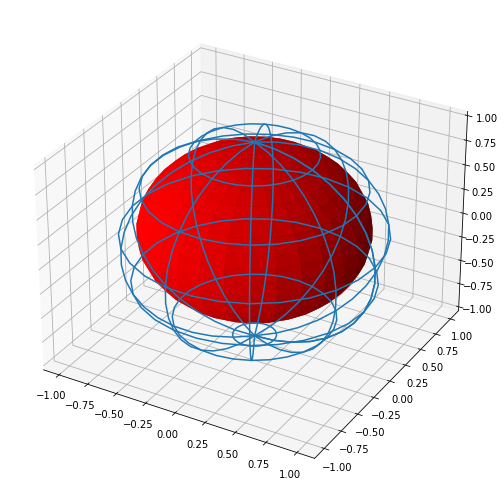

In [73]:
## gamma = 0.25 , p = 0.75
plt.rcParams["figure.figsize"] = [7.00*2, 3.50*2]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
r = 0.05
lam=0.25
p = 0.75
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
x2 = np.sqrt(1-lam)*np.cos(u) * np.sin(v)
y2 = np.sqrt(1-lam)*np.sin(u) * np.sin(v)
z2 = lam*(2*p-1)+np.cos(v)*(1-lam)
ax.plot_wireframe(x, y, z, rstride=3,cstride=3)
ax.plot_surface(x2,y2,z2,color='red')
plt.show()

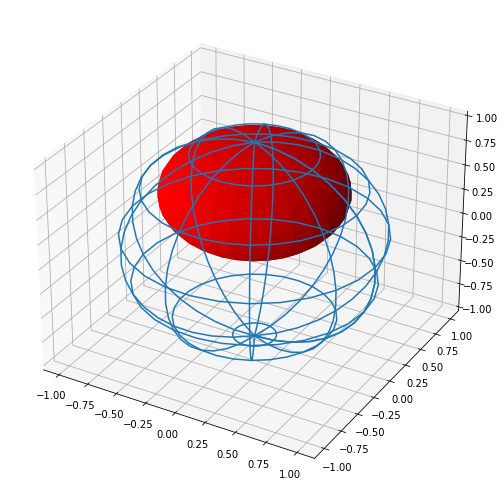

In [78]:
## gamma = 0.5 , p = 1
plt.rcParams["figure.figsize"] = [7.00*2, 3.50*2]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
r = 0.05
lam=0.5
p = 1
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
x2 = np.sqrt(1-lam)*np.cos(u) * np.sin(v)
y2 = np.sqrt(1-lam)*np.sin(u) * np.sin(v)
z2 = lam*(2*p-1)+np.cos(v)*(1-lam)
ax.plot_wireframe(x, y, z, rstride=3,cstride=3)
ax.plot_surface(x2,y2,z2,color='red')
plt.show()

Considering the examples given, $p$ modulates the $z$-axis position of the origin in the new sphere, while gamma modulates the stretch/flattening of the 
sphere.

## b)
Starting with the idealized circuit and simulating using QASM simulator, we get our general
GHz acting over 4 qubits.

In [35]:
# System Specification
n_qubits = 4
circ = QuantumCircuit(n_qubits)

# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
print(circ)

        ┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■─────────────░─┤M├─────────
        └───┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■────────░──╫─┤M├──────
             └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3 


Simulating this gate with the qiskit backend gives the following results. Note that the
results fluctuate around $\pm 5\%$, but nevertheless produce the entangled 4-qubit state expected.

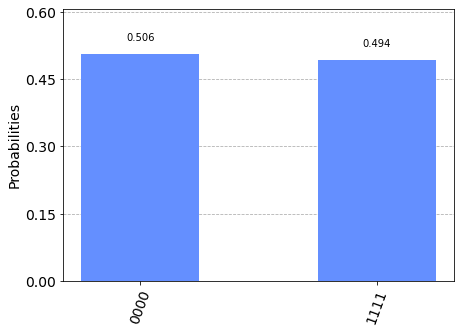

In [36]:
backend = Aer.get_backend('aer_simulator')

circ_comp = transpile(circ,backend)
circ_sim = backend.run(circ_comp,shots=1000)
circ_res = circ_sim.result()
counts = circ_res.get_counts(circ_comp)
plot_histogram(counts)

Now, I'm going to implement the thermal relaxation model suggested in the problemset,
with single qubit gate errors modeled at $p_s = 0.005$, two qubit gate errors at $p_t=0.025$,
and measurement errors of $0.007$. I am pulling the gate timings from IonQ's own statistics
for single qubit and two qubit operations along with measurement. These parameters should
match the expected error rates for IonQ qpus. For the model, like the tutorial, I assume
a normal distribution of Ts. Note that T1 is much larger than T2 (according to IonQ), so 
dephasing seems more likely than direct thermal relaxation.

In [37]:
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(1e7, 10e3, 4)
T2s = np.random.normal(2e5, 10e3, 4)  

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_h = 10000
time_cx = 210000
time_reset = 25000  # 1 microsecond
time_measure = 100000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_h  = [thermal_relaxation_error(t1, t2, time_h)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_h[j], "h", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx']
  Instructions with noise: ['h', 'cx', 'measure', 'reset']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('h', (0,)), ('h', (1,)), ('h', (2,)), ('h', (3,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2)), ('cx', (2, 3)), ('cx', (3, 0)), ('cx', (3, 1)), ('cx', (3, 2)), ('cx', (3, 3))]


Now we simulate with the noisy model.

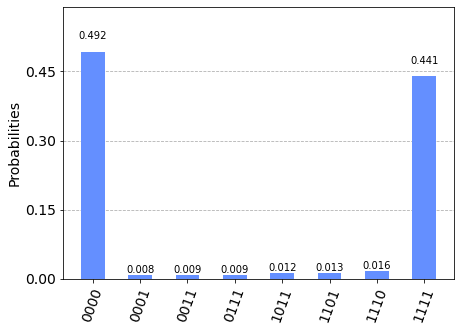

In [38]:
sim_thermal = AerSimulator(noise_model=noise_thermal)
sim_circ = transpile(circ,sim_thermal)
result_thermal = sim_thermal.run(sim_circ,shots=1000).result()
counts_thermal = result_thermal.get_counts(0)

plot_histogram(counts_thermal)

Based on the results shown above, we get worst-case scenario eror rates around 6-7%, which
is slightly underestimating the error rates given by IonQ for the circuit shown previously.
Worst case scenario on IonQ device would yield errors around 10%. Now if we run for greater shots.

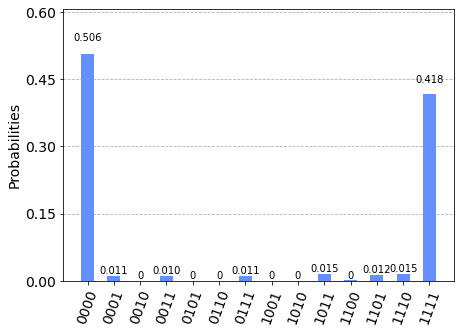

In [39]:
sim_thermal = AerSimulator(noise_model=noise_thermal)
sim_circ = transpile(circ,sim_thermal)
result_thermal = sim_thermal.run(sim_circ,shots=10000).result()
counts_thermal = result_thermal.get_counts(0)

plot_histogram(counts_thermal)

We again get error rates that hover around the 6-7% mark. Now for the cost estimation
and simulation on IonQ's backend.

............

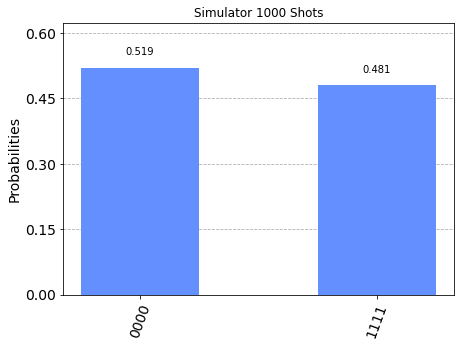

In [42]:
backend=provider.get_backend("ionq.simulator")
ionq_sim=circ
sim_1000_shots_job = backend.run(circ,shots=1000)
sim_1000_shots_results = sim_1000_shots_job.result()
plot_histogram(sim_1000_shots_results.get_counts(ionq_sim),title="Simulator 1000 Shots")

And for 10000 shots, along with a cost estimate for the qpus.

............

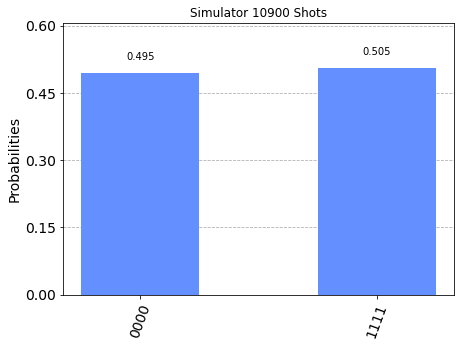

In [43]:
backend=provider.get_backend("ionq.simulator")
ionq_sim=circ
sim_1000_shots_job = backend.run(circ,shots=10000)
sim_1000_shots_results = sim_1000_shots_job.result()
plot_histogram(sim_1000_shots_results.get_counts(ionq_sim),title="Simulator 10900 Shots")

In [44]:
backend = provider.get_backend("ionq.qpu")
ionq_sim = circ
ionq_sim_trans = transpile(ionq_sim,backend)
cost_1000 = backend.estimate_cost(ionq_sim_trans,shots=1000)
cost_10000 = backend.estimate_cost(ionq_sim_trans,shots=10000)
print("Cost of 1000 shots: ", cost_1000)
print("Cost of 10000 shots: ",cost_10000)

Cost of 1000 shots:  {'additional_properties': {}, 'currency_code': 'USD', 'events': [<azure.quantum._client.models._models_py3.UsageEvent object at 0x7f4e17430910>, <azure.quantum._client.models._models_py3.UsageEvent object at 0x7f4e1751e350>], 'estimated_total': 1.0}
Cost of 10000 shots:  {'additional_properties': {}, 'currency_code': 'USD', 'events': [<azure.quantum._client.models._models_py3.UsageEvent object at 0x7f4e174732d0>, <azure.quantum._client.models._models_py3.UsageEvent object at 0x7f4e179ccf90>], 'estimated_total': 9.299999999999999}


So for 1000 shots, we have a cost estimated around \$1, while for 10000 shots the cost is around \$10. So we can try to run both on qpu!

..........................

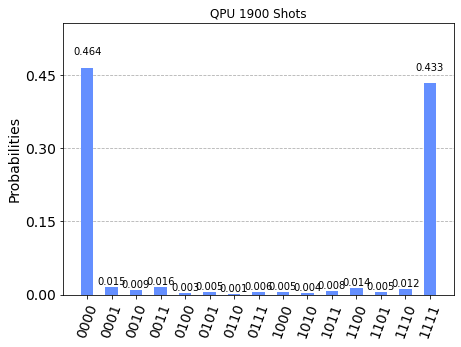

In [45]:
sim_1000_shots_job = backend.run(ionq_sim,shots=1000)
sim_1000_shots_results = sim_1000_shots_job.result()
plot_histogram(sim_1000_shots_results.get_counts(ionq_sim),title="QPU 1000 Shots")

...................................

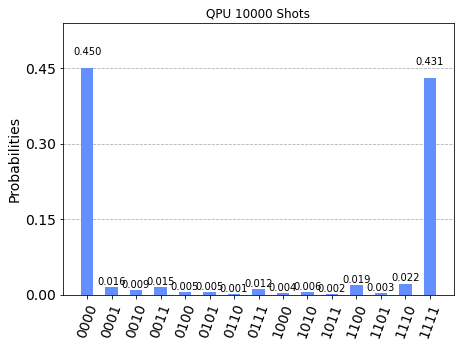

In [46]:
sim_1000_shots_job = backend.run(ionq_sim,shots=1000)
sim_1000_shots_results = sim_1000_shots_job.result()
plot_histogram(sim_1000_shots_results.get_counts(ionq_sim),title="QPU 10000 Shots")

Each of these jobs round in at just about 10% error, which makes sense based on taking worst case scenarios for the worst-case scenarios for resetting, single gate and
two gate operations, and measurement published by IonQ. In comparison to our own error estimation, we see that we underestimated the error by around 2.5-3%. While simulating
does underestimate the error, it doest get us to a much more realized scenario in comparison to real experiment. Also, when comparing shots, we get about a 1% increase in error
between 1000 and 10000 shots, which we didn't observe in the simulated case. I'm unsure if this is statistical noise, however, and don't want to overspend on running this simulation! 